# Ch4. Training

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## MNIST Dataset

In [2]:
from tensorflow.keras.datasets import mnist
(x_train, t_train), (x_test, t_test) = mnist.load_data()

In [3]:
'Flatten'
x_train = x_train.reshape([-1, 28 * 28])
x_test = x_test.reshape([-1, 28 * 28])

'Normalize'
x_train = x_train / 255
x_test = x_test / 255

'One-Hot Encoding'
from tensorflow.keras.utils import to_categorical
t_train = to_categorical(t_train, 10)
t_test = to_categorical(t_test, 10)

## Loss function 손실 함수
#### MSE, mean squared error 평균 제곱 오차

In [4]:
def mean_squared_error(y, t):
    return 0.5 * np.sum((y - t) ** 2)

#### CEE, cross entropy error 교차 엔트로피 오차

In [5]:
def cross_entropy_error(y, t):
    delta = 1e-7
    return -np.sum(t * np.log(y + delta))

#### CEE, cross entropy error 교차 엔트로피 오차 (Batch용)

In [6]:
'For One-Hot Encoded'
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    batch_size = y.shape[0]
    return -np.sum(t * np.log(y)) / batch_size

## Mini-Batch Training

In [7]:
train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]

## Gradient 기울기

In [8]:
def numerical_gradient(f, x):
    h = 1e-4
    grad = np.zeros_like(x)
    
    for idx in range(x.size):
        tmp_val = x[idx]
        
        x[idx] = tmp_val + h
        fxh1 = f(x)
        
        x[idx] = tmp_val - h
        fxh2 = f(x)
        
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val
        
    return grad

In [9]:
'Example: f(x) = x0^2 + x1^2'
test_func = lambda x: x[0]**2 + x[1]**2

## Gradient Descent Method 경사 하강법

In [10]:
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x
    
    for i in range(step_num):
        grad = numerical_gradient(f, x)
        x -= lr * grad
    return x

In [11]:
init_x = np.array([-3., 4.])
gradient_descent(test_func, init_x=init_x, lr=0.1)

array([-6.11110793e-10,  8.14814391e-10])

In [12]:
from common.functions import softmax, cross_entropy_error
from common.gradient import numerical_gradient

class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2, 3)

    def predict(self, x):
        return np.dot(x, self.W)
    
    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)
        return loss

## 2-Layers NN 2층 신경망 구현

In [13]:
from common.functions import *
from common.gradient import numerical_gradient


class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads

## 2-Layers NN 2층 신경망 구현
- Mini-Batch Training

In [14]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# 하이퍼파라미터
iters_num = 10000  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0]
batch_size = 100   # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
#     grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))


train acc, test acc | 0.10441666666666667, 0.1028
train acc, test acc | 0.7839, 0.7897
train acc, test acc | 0.87855, 0.8831
train acc, test acc | 0.8983833333333333, 0.9005
train acc, test acc | 0.9073833333333333, 0.9107
train acc, test acc | 0.91485, 0.917
train acc, test acc | 0.92, 0.9213
train acc, test acc | 0.9249, 0.9259
train acc, test acc | 0.9273333333333333, 0.9277
train acc, test acc | 0.9314, 0.9316
train acc, test acc | 0.9347333333333333, 0.935
train acc, test acc | 0.9372, 0.9372
train acc, test acc | 0.9396666666666667, 0.939
train acc, test acc | 0.9411666666666667, 0.9404
train acc, test acc | 0.9440833333333334, 0.9428
train acc, test acc | 0.9462333333333334, 0.9447
train acc, test acc | 0.9468833333333333, 0.9467


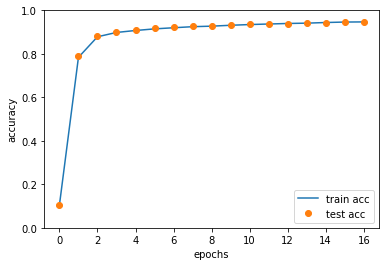

In [15]:
# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
# plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.plot(x, test_acc_list, 'o', label='test acc')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()